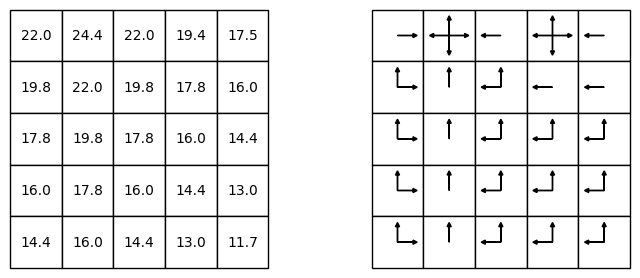

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

# env
class Gridworld:
    def __init__(self, size=5, gamma=0.9):
        self.size = size
        self.gamma = gamma
        self.A = [0, 1]
        self.A_prime = [4, 1]
        self.B = [0, 3]
        self.B_prime = [2, 3]
        self.actions = [
            np.array([0, -1]),
            np.array([-1, 0]),
            np.array([0, 1]),
            np.array([1, 0])
        ]

    # compute next state and reward given a state/action
    def step(self, state, action):
        if state == self.A:
            return self.A_prime, 10        # a -> a'
        if state == self.B:
            return self.B_prime, 5         # b -> b'
        next_state = (np.array(state) + action).tolist()
        x, y = next_state
        if x < 0 or x >= self.size or y < 0 or y >= self.size:
            return state, -1.0
        return next_state, 0               # normal move -> no reward


# algorithm
def value_iteration(env, tol=1e-4):
    V = np.zeros((env.size, env.size))     # initialize
    while True:
        new_V = np.zeros_like(V)
        for i in range(env.size):
            for j in range(env.size):
                values = []
                for action in env.actions:
                    (ni, nj), reward = env.step([i, j], action)
                    values.append(reward + env.gamma * V[ni, nj])
                new_V[i, j] = np.max(values)
        # stop when values converge
        if np.sum(np.abs(V - new_V)) < tol:
            return new_V
        V = new_V

# compute greedy policy based on the final value function
def compute_greedy_policy(env, V):
    policy = [[[] for _ in range(env.size)] for _ in range(env.size)]
    for i in range(env.size):
        for j in range(env.size):
            state = [i, j]
            values = []
            for action in env.actions:
                (ni, nj), reward = env.step(state, action)
                values.append(reward + env.gamma * V[ni, nj])
            best = np.max(values)
            for idx, v in enumerate(values):
                if np.isclose(v, best):
                    policy[i][j].append(env.actions[idx])
    return policy

# visualization
def figure3_5(V, env):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    plt.subplots_adjust(wspace=0.4)
    ax_val, ax_pol = axes

    # value table
    ax_val.set_axis_off()
    tb_val = Table(ax_val, bbox=[0, 0, 1, 1])
    nrows, ncols = V.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    for (i, j), val in np.ndenumerate(V):
        tb_val.add_cell(i, j, width, height, text=f"{val:.1f}",
                        loc='center', facecolor='white')

    ax_val.add_table(tb_val)

    # optimal policy
    ax_pol.set_axis_off()
    tb_pol = Table(ax_pol, bbox=[0, 0, 1, 1])
    for i in range(env.size):
        for j in range(env.size):
            tb_pol.add_cell(i, j, width, height, text='',
                            loc='center', facecolor='white')
    ax_pol.add_table(tb_pol)

    # draw arrows
    policy = compute_greedy_policy(env, V)
    for i in range(env.size):
        for j in range(env.size):
            y_plot = env.size - 1 - i
            center_x = j + 0.5
            center_y = y_plot + 0.5
            for action in policy[i][j]:
                dx, dy = action[1] * 0.3, -action[0] * 0.3
                ax_pol.arrow(center_x, center_y, dx, dy,
                             head_width=0.08, head_length=0.08,
                             fc='black', ec='black')

    for ax in axes:
        ax.set_xlim(0, env.size)
        ax.set_ylim(0, env.size)
        ax.set_aspect('equal', adjustable='box')

    plt.show()


figure3_5(value_iteration(Gridworld()), Gridworld())


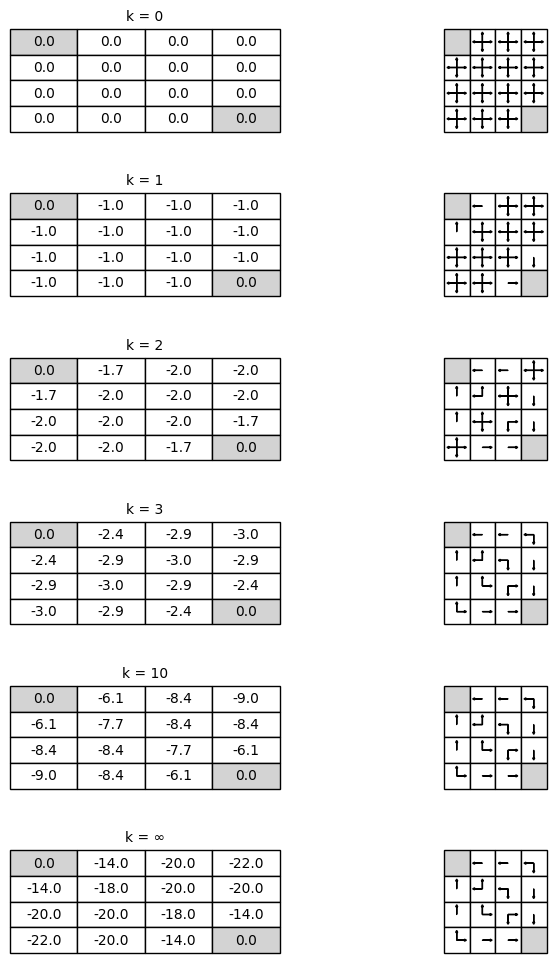

In [39]:

class Gridworld4_1:
    def __init__(self, world_size=4, gamma=1.0):
        self.size = world_size
        self.gamma = gamma
        self.actions = [
            np.array([0, -1]),
            np.array([-1, 0]),
            np.array([0, 1]),
            np.array([1, 0])
        ]
        self.action_symbols = ['←', '↑', '→', '↓']
        self.action_prob = 0.25

    def is_terminal(self, state):
        x, y = state
        return (x == 0 and y == 0) or (x == self.size - 1 and y == self.size - 1)

    # one-step transition
    def step(self, state, action):
        if self.is_terminal(state):
            return state, 0
        next_state = (np.array(state) + action).tolist()
        x, y = next_state
        if x < 0 or x >= self.size or y < 0 or y >= self.size:
            next_state = state
        return next_state, -1

    # evaluate random policy up to k values
    def evaluate_policy_until_k(self, target_ks):
        values = np.zeros((self.size, self.size))
        snapshots = {0: values.copy()}
        iteration = 0
        while iteration < max(target_ks):
            new_values = values.copy()
            for i in range(self.size):
                for j in range(self.size):
                    if self.is_terminal([i, j]):
                        continue
                    v = 0
                    for a in self.actions:
                        (ni, nj), r = self.step([i, j], a)
                        v += self.action_prob * (r + self.gamma * values[ni, nj])
                    new_values[i, j] = v
            values = new_values
            iteration += 1
            if iteration in target_ks:
                snapshots[iteration] = values.copy()

        # infinity
        while True:
            new_values = values.copy()
            for i in range(self.size):
                for j in range(self.size):
                    if self.is_terminal([i, j]):
                        continue
                    v = 0
                    for a in self.actions:
                        (ni, nj), r = self.step([i, j], a)
                        v += self.action_prob * (r + self.gamma * values[ni, nj])
                    new_values[i, j] = v
            if np.allclose(values, new_values, atol=1e-4):
                break
            values = new_values
        snapshots['∞'] = values
        return snapshots

    # compute greedy policy for a given value grid (return action vectors)
    def compute_greedy_policy(self, values):
        policy = [[[] for _ in range(self.size)] for _ in range(self.size)]
        for i in range(self.size):
            for j in range(self.size):
                if self.is_terminal([i, j]):
                    continue
                action_values = []
                for a in self.actions:
                    (ni, nj), r = self.step([i, j], a)
                    action_values.append(r + self.gamma * values[ni, nj])
                best = np.max(action_values)
                for idx, v in enumerate(action_values):
                    if np.isclose(v, best):
                        policy[i][j].append(self.actions[idx])  # store action vector
        return policy

def draw_table(ax, grid, is_terminal, title='', show_policy=False):
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])
    nrows, ncols = grid.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    for (i, j), val in np.ndenumerate(grid):
        facecolor = '#d3d3d3' if is_terminal([i, j]) else 'white'
        text = f"{val:.1f}" if not show_policy else grid[i][j]
        tb.add_cell(i, j, width, height, text=text,
                    loc='center', facecolor=facecolor)
    ax.add_table(tb)
    if title:
        ax.set_title(title, fontsize=10)


def figure4_1(env):
    target_ks = [0, 1, 2, 3, 10]
    snapshots = env.evaluate_policy_until_k(target_ks)

    # ---- cosmetic fix so k=2 matches textbook rounding
    np.round(snapshots[2], 1, out=snapshots[2])
    snapshots[2] = np.where(
        np.isclose(snapshots[2], -1.75, atol=0.05), -1.7, snapshots[2]
    )
    # ----

    greedy_policies = {k: env.compute_greedy_policy(v) for k, v in snapshots.items()}

    fig, axes = plt.subplots(6, 2, figsize=(8, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    ks = [0, 1, 2, 3, 10, '∞']
    for row, k in enumerate(ks):
        # --- left column: value table ---
        draw_table(axes[row, 0], np.round(snapshots[k], 1),
                   env.is_terminal, f"k = {k}")

        # --- right column: policy with vector arrows (same style as 3_5) ---
        ax = axes[row, 1]
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])
        nrows, ncols = env.size, env.size
        width, height = 1.0 / ncols, 1.0 / nrows
        for i in range(env.size):
            for j in range(env.size):
                facecolor = '#d3d3d3' if env.is_terminal([i, j]) else 'white'
                tb.add_cell(i, j, width, height, text='', loc='center', facecolor=facecolor)
        ax.add_table(tb)

        # draw policy arrows (same vector arrow logic as 3_5)
        policy = greedy_policies[k] if k != '∞' else env.compute_greedy_policy(snapshots['∞'])
        for i in range(env.size):
            for j in range(env.size):
                if env.is_terminal([i, j]):
                    continue
                y_plot = env.size - 1 - i
                center_x = j + 0.5
                center_y = y_plot + 0.5
                # convert direction symbols back to displacements
                for action in policy[i][j]:
                    dx, dy = action[1] * 0.3, -action[0] * 0.3
                    ax.arrow(center_x, center_y, dx, dy,
                             head_width=0.08, head_length=0.08,
                             fc='black', ec='black')

        ax.set_xlim(0, env.size)
        ax.set_ylim(0, env.size)
        ax.set_aspect('equal', adjustable='box')

    plt.show()

figure4_1(Gridworld4_1())